In [1]:
try:
    from openmdao.utils.notebook_utils import notebook_mode
except ImportError:
    !python -m pip install openmdao[notebooks]

# Simple Optimization

## The Paraboloid

This example finds the minimum point in a paraboloid defined by:

\begin{align}
f(x,y) &= (x-3)^2 + x y + (y+4)^2 - 3
\end{align}

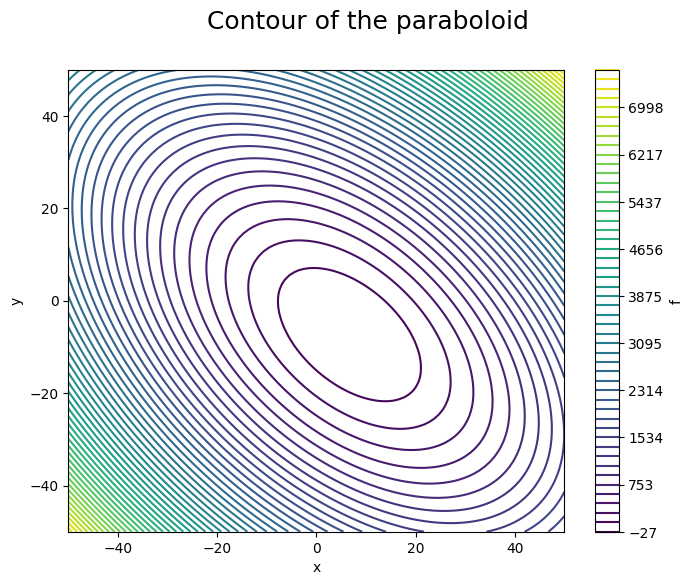

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-50, 50, 100)
y = np.linspace(-50, 50, 100)
XX, YY = np.meshgrid(x, y)
ZZ = (XX - 3)**2 + XX * YY + (YY + 4)**2 - 3

plt.figure(figsize=(8, 6))
plt.contour(XX, YY, ZZ, levels=np.linspace(np.min(ZZ), np.max(ZZ), 50))
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='f')
plt.suptitle('Contour of the paraboloid', fontsize=18);


## Finding the minimum with OpenMDAO

The following script uses OpenMDAO to find the minimum of the paraboloid.

In [3]:
import openmdao.api as om

# build the model
prob = om.Problem()

prob.model.add_subsystem('paraboloid', om.ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'))

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('paraboloid.x', lower=-50, upper=50)
prob.model.add_design_var('paraboloid.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')

prob.setup()

# Set initial values.
prob.set_val('paraboloid.x', 3.0)
prob.set_val('paraboloid.y', -4.0)

# run the optimization
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.33333333333333
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------


In [4]:
def test_1():
    from openmdao.utils.assert_utils import assert_near_equal
    assert_near_equal(prob.get_val('paraboloid.x'), 6.66666666, tolerance=1.0E-5)
    assert_near_equal(prob.get_val('paraboloid.y'), -7.33333333, tolerance=1.0E-5)
    assert_near_equal(prob.get_val('paraboloid.f'), -27.33333333, tolerance=1.0E-5)
        

## Step-by-step explanation

First, we import the OpenMDAO API into the namespace `om`

In [5]:
import openmdao.api as om

### Instantiating a Problem

An OpenMDAO `Problem` couples a computational _model_ with some sort of _driver_ that executes that model.

The default model is an empty _Group_, to which we can add _Components_ or _Groups_ of _Components_.

The default driver simply executes the model a single time.  More commonly, you'll use drivers that perform optimization (such as ScipyOptimizeDriver or pyOptSparseDriver) or execute the model to perform a design-of-experiments (DOEDriver).

In [6]:
prob = om.Problem()

### Building our Model

In this case, our model consists of a single component; an `ExecComp` that executes a user-defined function.  We've given it the mathematical equation for our paraboloid.

In [7]:
prob.model.add_subsystem('paraboloid', om.ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'));

### Specifying the Driver

In this case we wish to find the minimum value on the contour of the paraboloid.  To do this, we use an optimization driver.  Optimization drivers vary the values of some _design variables_ to minimize the value of some _objective function_.  Many optimiation techniques can also respect some set of _constraints_ imposed upon the optimization, but this particular problem is unconstrained.  We're going to use OpenMDAO's built in `ScipyOptimizeDriver`, which uses the optimizers from [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to perform the optimization.  In this case, the design variables are `x` and `y`, and the objective is `f`.

In [8]:
# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('paraboloid.x', lower=-50, upper=50)
prob.model.add_design_var('paraboloid.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')

### Setup the Problem

The next step is setting up the problem.  This is a bit analogous to compiling source code when programming.  OpenMDAO allocates the necessary data structures that enable pass data between different parts of our model and to compute the derivatives of our model for the optimizer.

In [9]:
prob.setup()

(examples_paraboloid:specifying_initial_values)=
### Specifying Initial Values

During the course of optimization, OpenMDAO is going to vary the value of the design variables (`x` and `y`) in an attempt to find the minimum value of `f`.  The optimization algorithms involved generally need the user to specify a starting point.  This is accomplished using the `set_val` method of the `Problem` class.

OpenMDAO will, by default, issue a warning if the initial values of the design variables exceed their specified bounds. This behavior may be changed by setting the driver option `invalid_desvar_behavior` to one of `'warn'`, `'raise'`, or `'ignore'`, with `'warn'` being the default. Some users may find it useful to override this default value globally, which may be accomplished by setting the environment variable `OPENMDAO_INVALID_DESVAR_BEHAVIOR` to one of `'warn'`, `'raise'`, or `'ignore'`.

In [10]:
# Set initial values.
prob.set_val('paraboloid.x', 3.0)
prob.set_val('paraboloid.y', -4.0)

### Running the Optimization Driver

Finally, we run the optimization driver to actually find the minimum value.  The ScipyOptimizeDriver will output the results of the optimization to standard output.  In addition, `run_driver` will return a `fail` flag.  If `True`, this means the optimization driver believes it failed to successfully find an optimal solution.

In [11]:
# run the optimization
prob.run_driver()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.33333333333333
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------


False

### Getting the results

We can access the values of variables in our model by using the `get_val` method of `Problem`.

In [12]:
print('Optimal x value: ', prob.get_val('paraboloid.x'))
print('Optimal y value: ', prob.get_val('paraboloid.y'))
print('Objective value: ', prob.get_val('paraboloid.f'))

Optimal x value:  [6.66666667]
Optimal y value:  [-7.33333333]
Objective value:  [-27.33333333]


In [13]:
from openmdao.utils.assert_utils import assert_near_equal
assert_near_equal(prob.get_val('paraboloid.x'), 6.66666666, tolerance=1.0E-5)
assert_near_equal(prob.get_val('paraboloid.y'), -7.33333333, tolerance=1.0E-5)
assert_near_equal(prob.get_val('paraboloid.f'), -27.33333333, tolerance=1.0E-5)

1.2195109964002665e-10